## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

### split train set and test set

In [3]:
# Read the sampled dataset
df=pd.read_csv('./CICIDS2018_sample_km.csv')

In [4]:
df=df.dropna()

In [5]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [7]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [8]:
features = df.dtypes[df.dtypes != 'object'].index

In [9]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [10]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [11]:
X_fs = df[fs].values

In [12]:
X_fs.shape

(36457, 46)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [13]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [14]:
X_fss = fcbf.fit_transform(X_fs,y)

In [15]:
X_fss.shape

(36457, 20)

### Re-split train & test sets after feature selection

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.7, test_size = 0.3, random_state = 0,stratify = y)

In [17]:
X_train.shape

(25519, 20)

In [18]:
pd.Series(y_train).value_counts()

0     7464
10    6935
6     4023
4     1392
5     1211
8     1014
1     1008
12     828
14     660
2      398
7      290
3      160
13      60
9       39
11      37
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [21]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={12:1000,14:1000,2:1000,7:1000,3:1000,13:1000,9:1000,11:1000})

In [22]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [23]:
pd.Series(y_train).value_counts()

0     7464
10    6935
6     4023
4     1392
5     1211
8     1014
1     1008
12    1000
11    1000
2     1000
3     1000
14    1000
7     1000
9     1000
13    1000
Name: count, dtype: int64

In [24]:
criteria = ['gini', 'entropy']

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9605046626439934
Precision of XGBoost: 0.9608074161719029
Recall of XGBoost: 0.9605046626439934
F1-score of XGBoost: 0.9475642645652633
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3199
           1       1.00      0.99      1.00       432
           2       0.94      0.85      0.89       170
           3       0.84      0.94      0.89        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       0.99      1.00      1.00      1725
           7       0.96      1.00      0.98       125
           8       1.00      1.00      1.00       434
           9       0.50      1.00      0.67        16
          10       1.00      1.00      1.00      2973
          11       0.00      0.00      0.00        16
          12       0.91      0.06      0.11       355
          13       0.42      0.72      0.53        25
          14       1.00      0

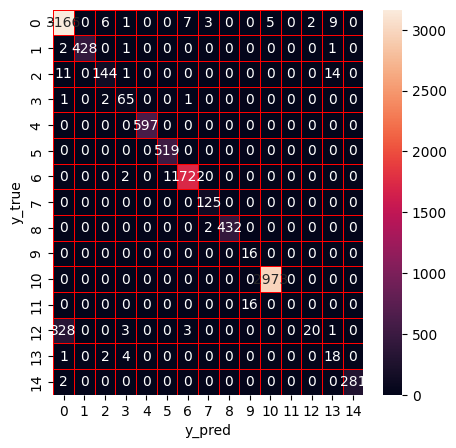

In [25]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [26]:
X_train_hpo, X_val_hpo, y_train_hpo, y_val_hpo = train_test_split(X_train, y_train, train_size=0.9, test_size=0.1, random_state=0, stratify=y_train)

In [27]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val_hpo)
    score = accuracy_score(y_val_hpo, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:30<00:00,  1.54s/trial, best loss: -0.9330112721417069]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.21588607021942952, 'max_depth': 85.0, 'n_estimators': 55.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.91690821 0.91239936 0.91272142 0.91400966 0.91819646 0.91626409
 0.91658615 0.92010309 0.91720361 0.92074742]
Average Accuracy: 0.9165 (+/- 0.0027)

Accuracy of XGBoost: 0.9525507405375754
Precision of XGBoost: 0.9423787656906744
Recall of XGBoost: 0.9525507405375754
F1-score of XGBoost: 0.9463832010541973
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3199
           1       1.00      0.99      1.00       432
           2       0.93      0.85      0.89       170
           3       0.84      0.94      0.89        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       0.99      1.00      1.00      1725
           7       0.98      1.00      0.99       125
           8       1.00      1.00      1.00       434
           9       0.50      1.00      0.67        16
          10       1.00      1.

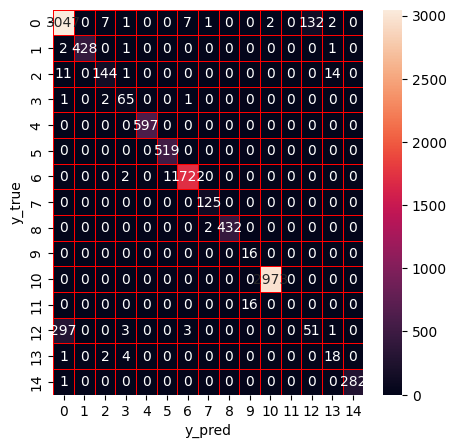

Final Detection Rate (DR) on Test Set: 0.9596
Final False Alarm Rate (FAR) on Test Set: 0.0475



In [28]:
xg = xgb.XGBClassifier(learning_rate=0.21588607021942952, n_estimators=55, max_depth = 85)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(xg, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()


def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")




In [29]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.954927774730298
Precision of RF: 0.9449455253202275
Recall of RF: 0.954927774730298
F1-score of RF: 0.9488420935321841
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3199
           1       1.00      0.99      1.00       432
           2       0.92      0.91      0.91       170
           3       0.89      0.94      0.92        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       1.00      1.00      1.00      1725
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       434
           9       0.50      1.00      0.67        16
          10       1.00      1.00      1.00      2973
          11       0.00      0.00      0.00        16
          12       0.32      0.17      0.22       355
          13       0.72      0.52      0.60        25
          14       1.00      1.00      1.00       28

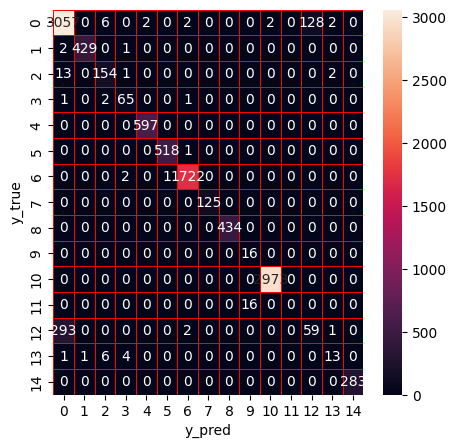

In [30]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [31]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train_hpo,y_train_hpo)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [01:31<00:00,  4.58s/trial, best loss: -0.9230273752012882]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 45.0, 'max_features': 6.0, 'min_samples_leaf': 5.0, 'min_samples_split': 4.0, 'n_estimators': 155.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.91884058 0.92012882 0.92173913 0.91884058 0.92270531 0.9178744
 0.92077295 0.92364691 0.92525773 0.9255799 ]
Average Accuracy: 0.9215 (+/- 0.0026)

Accuracy of RF: 0.9599561162918266
Precision of RF: 0.9459409801497104
Recall of RF: 0.9599561162918266
F1-score of RF: 0.9484994808856094
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3199
           1       1.00      0.99      0.99       432
           2       0.92      0.91      0.91       170
           3       0.89      0.94      0.92        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       1.00      1.00      1.00      1725
           7       0.98      1.00      0.99       125
           8       1.00      1.00      1.00       434
           9       0.48      1.00      0.65        16
          10       1.00      1.00      1.00      297

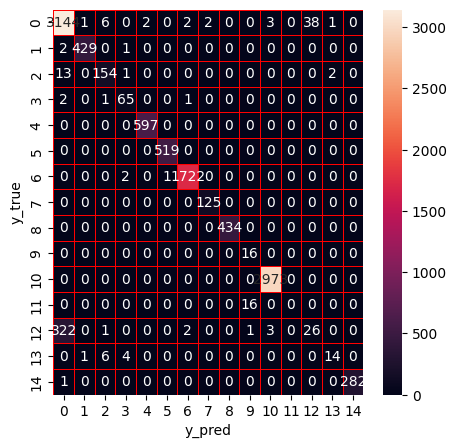

Final Detection Rate (DR) on Test Set: 0.9561
Final False Alarm Rate (FAR) on Test Set: 0.0172



In [32]:
rf_hpo = RandomForestClassifier(n_estimators =155, min_samples_leaf = 5, max_depth = 45, min_samples_split = 4, max_features = 6, criterion = criteria[best['criterion']])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(rf_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()


def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [33]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9486194916803803
Precision of DT: 0.941202071192239
Recall of DT: 0.9486194916803803
F1-score of DT: 0.9444802155720493
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3199
           1       1.00      0.99      0.99       432
           2       0.90      0.91      0.90       170
           3       0.84      0.94      0.89        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       1.00      1.00      1.00      1725
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       434
           9       0.50      1.00      0.67        16
          10       1.00      1.00      1.00      2973
          11       0.00      0.00      0.00        16
          12       0.23      0.16      0.19       355
          13       0.68      0.52      0.59        25
          14       1.00      1.00      1.00       2

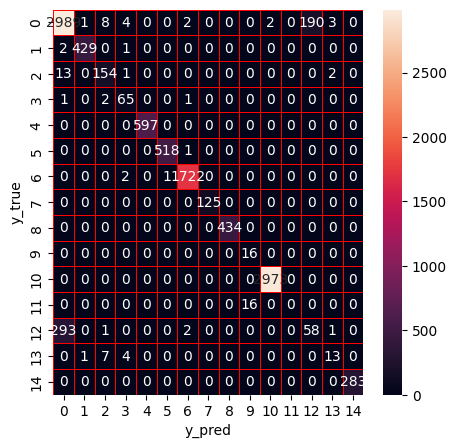

In [34]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [36]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:04<00:00, 10.10trial/s, best loss: -0.9426731078904992]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 42.0, 'max_features': 20.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.91078905 0.90821256 0.9136876  0.9078905  0.91400966 0.9136876
 0.90885668 0.91333763 0.91591495 0.92171392]
Average Accuracy: 0.9128 (+/- 0.0040)

Accuracy of DT: 0.9485280672883525
Precision of DT: 0.9417488766517138
Recall of DT: 0.9485280672883525
F1-score of DT: 0.9447789459530634
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3199
           1       1.00      0.99      0.99       432
           2       0.90      0.91      0.90       170
           3       0.88      0.94      0.91        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       1.00      1.00      1.00      1725
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       434
           9       0.50      1.00      0.67        16
          10       1.00      1.00      1.00      297

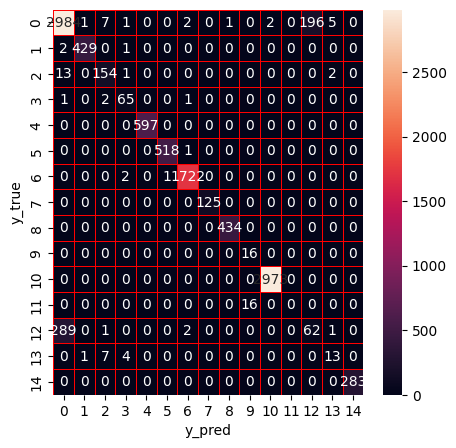

Final Detection Rate (DR) on Test Set: 0.9606
Final False Alarm Rate (FAR) on Test Set: 0.0672



In [37]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 1, max_depth = 42, min_samples_split = 2, max_features = 20, criterion = criteria[best['criterion']])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(dt_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [38]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9544706527701591
Precision of ET: 0.9444032745982549
Recall of ET: 0.9544706527701591
F1-score of ET: 0.9483973465906087
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3199
           1       1.00      0.99      1.00       432
           2       0.92      0.91      0.91       170
           3       0.89      0.94      0.92        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       1.00      1.00      1.00      1725
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       434
           9       0.50      1.00      0.67        16
          10       1.00      1.00      1.00      2973
          11       0.00      0.00      0.00        16
          12       0.30      0.16      0.21       355
          13       0.72      0.52      0.60        25
          14       1.00      1.00      1.00       

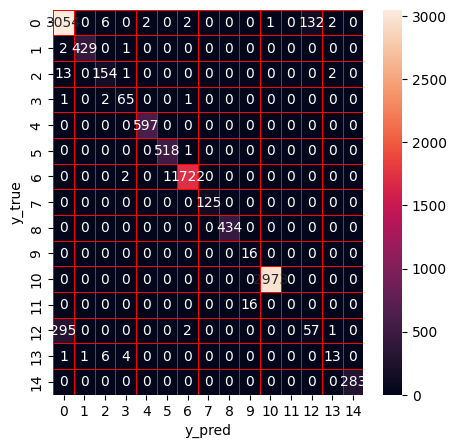

In [39]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [40]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:54<00:00,  2.73s/trial, best loss: -0.907890499194847]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 28.0, 'max_features': 19.0, 'min_samples_leaf': 3.0, 'min_samples_split': 7.0, 'n_estimators': 92.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.87954911 0.87600644 0.88148148 0.87826087 0.8705314  0.87890499
 0.88019324 0.88563144 0.89271907 0.89143041]
Average Accuracy: 0.8815 (+/- 0.0064)

Accuracy of ET: 0.9375571402450174
Precision of ET: 0.9348962547278136
Recall of ET: 0.9375571402450174
F1-score of ET: 0.9239774474721888
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3199
           1       1.00      0.99      0.99       432
           2       0.93      0.66      0.77       170
           3       1.00      0.70      0.82        69
           4       0.99      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       0.87      1.00      0.93      1725
           7       0.99      0.64      0.78       125
           8       0.90      1.00      0.95       434
           9       0.50      1.00      0.67        16
          10       1.00      0.99      1.00      29

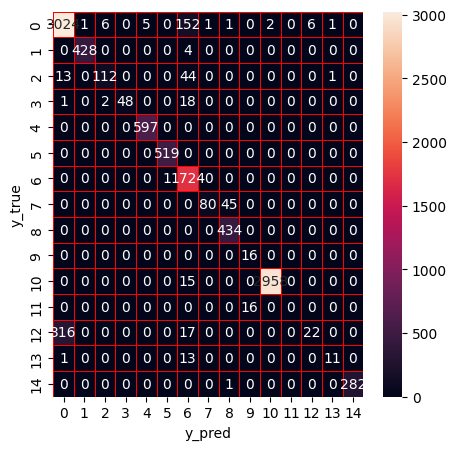

Final Detection Rate (DR) on Test Set: 0.9572
Final False Alarm Rate (FAR) on Test Set: 0.0547



In [41]:
et_hpo = ExtraTreesClassifier(n_estimators = 92, min_samples_leaf = 3, max_depth = 28, min_samples_split = 7, criterion=criteria[best['criterion']])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(et_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

et_hpo.fit(X_train,y_train)
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [42]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [43]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,10,10,10,10
1,10,10,10,10
2,12,12,0,12
3,5,5,5,5
4,0,0,0,0


In [44]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [45]:
dt_train.shape

(31047, 1)

In [46]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9484366428963248
Precision of Stacking: 0.9416230229136365
Recall of Stacking: 0.9484366428963248
F1-score of Stacking: 0.9446730405439633
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3199
           1       1.00      0.99      0.99       432
           2       0.90      0.91      0.90       170
           3       0.88      0.94      0.91        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       1.00      1.00      1.00      1725
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       434
           9       0.50      1.00      0.67        16
          10       1.00      1.00      1.00      2973
          11       0.00      0.00      0.00        16
          12       0.24      0.17      0.20       355
          13       0.62      0.52      0.57        25
          14       1.00   

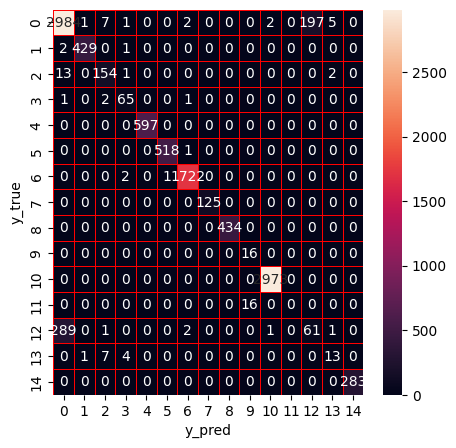

In [47]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [49]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train_hpo, y_train_hpo)
    y_pred = clf.predict(X_val_hpo)
    score = accuracy_score(y_val_hpo, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:23<00:00,  1.18s/trial, best loss: -0.9188405797101449]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.033918787865656726, 'max_depth': 44.0, 'n_estimators': 10.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.91690821 0.91239936 0.91497585 0.91465378 0.91755233 0.91723027
 0.91723027 0.91978093 0.91849227 0.91978093]
Average Accuracy: 0.9169 (+/- 0.0022)

Accuracy of XGBoost: 0.9484366428963248
Precision of XGBoost: 0.9416230229136365
Recall of XGBoost: 0.9484366428963248
F1-score of XGBoost: 0.9446730405439633
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3199
           1       1.00      0.99      0.99       432
           2       0.90      0.91      0.90       170
           3       0.88      0.94      0.91        69
           4       1.00      1.00      1.00       597
           5       1.00      1.00      1.00       519
           6       1.00      1.00      1.00      1725
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       434
           9       0.50      1.00      0.67        16
          10       1.00      1.

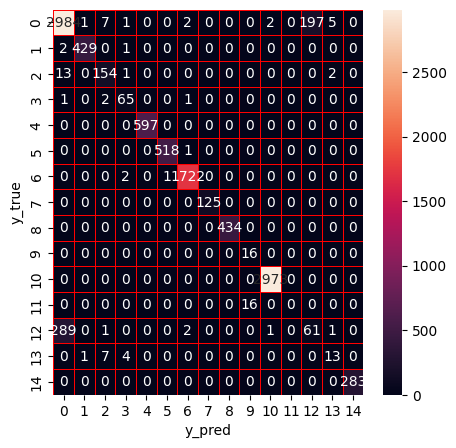

Final Detection Rate (DR) on Test Set: 0.9606
Final False Alarm Rate (FAR) on Test Set: 0.0672



In [50]:
xg = xgb.XGBClassifier(learning_rate=0.2648613041782575, n_estimators = 70, max_depth = 69)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(xg, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")
